# Clustering and Machine Learning
## Advanced Parameter Optimization
It's easy to make trading strategies. It's hard to make good ones. As in strategies that make money. In my experience I've found that it's possible to take bad strategies and turn them into profitable ones by finding the optimal parameters.  

As I get deeper into the world of algorithm trading I've found that the strategies I tend to use are often very simple, rudementary ideas that many others have tried. However, I have yet to find/meet anyone who has been able to take one of these generic algorithms and turn a profit with it. This is most likely because they don't know and are guessing what the inputs should be. In this notebook I will walk through a mock process to not only find these parameters, but also create simple ML models that can predict returns based on hypothetical algorithm inputs.  

Another advantage of these clustering/selection methods is that if they are good enough they can be wrapped up as a function and added into a live code. Then the live trading strategy can be set to auto update it's parameters every day, once a week, after +-10% price moves, etc.  

Every plot in this notebook in 3D. Technically since we're just looking for two parameter values we could do this whole thing without a single plot, but that wouldn't be fun. A 2D Parameters vs Returns plot would also be boring, not to mention unrealistic as most models have many inputs. 3D allows for two parameters and returns to be plotted and is still visually intuitive. Lastly you can make a 3D plot with each axis for a different parameter and the "density" of the datapoint relative to the return. In this case you can think of it as searching for high density clusters opposed to spatially close ones. Past that you're just going to have to look at matricies, but it's important to build intuition here and I hope the 3D plots help do that.  

The data set I use here is posted in the reposity, although please note that I have pre-scaled the Parameter values to have similar ranges, but **not** the returns.

Before getting into it, I'd like to discuss the reasons I believe I have yet to meet other people doing this.
* You need LOTS of data. Cryptocurrencies are highly volatile and the shorter the time span the easier it is to find  parameters that work. Over larger periods of time more and more parameter combinations will prove to be losing strategies
* If you do have lots of data this will take a long time to backtest. Anywhere from 7 hours to two weeks running continuously on AWS to find something akin to the BacktestResults.csv  
* Assuming you do the above, you then need find the parameters. Many people may naively try picking the parameters associated with the highest return, admittedly I've tried this, and I can guarantee that this will lose money
### Dependancies

In [1]:
import csv
import numpy as np
import pandas as pd
import random
import statistics as st
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines
from sklearn import tree, linear_model
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN
from sklearn.metrics.pairwise import pairwise_distances_argmin

np.set_printoptions(threshold=np.nan)
pd.set_option('display.max_columns', None)

### Interactive Plotting
Currently all the plots in this notebook are stationary. I tried to pick views that best show the data, but if you really want to get a more in depth view of the plots and play with them yourself unhash the line of text below. I found the interactive plots useful for data exploration, but clunky to look at in general so I have left it off.

In [2]:
# %matplotlib notebook

### Data and 3D Plot
First import the data into an array and plot it with the x-axis as Parameter 1, y-axis as Parameter 2, and z-axis as the Returns. The data points are also color coded by return for clarity. A second view is shown of the xy plane. Here we clearly see a curve from the bottom left to top right corning that defines the line between parameters that make money and those that don't trade (0 return). At the extremities parameter combinations lose mosey.

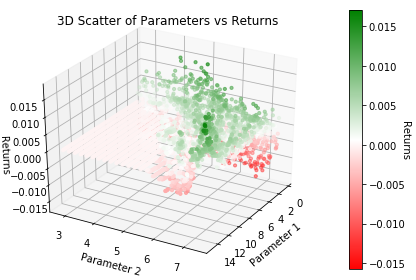

In [3]:
data = pd.read_csv('/path/BacktestResults.csv', header = 0)
data = np.array(data)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
cmap = LinearSegmentedColormap.from_list('rg',['r', 'w', 'g'], N=256) 
img = ax.scatter(data[:, 1], data[:, 2], data[:, 0], c=data[:, 0], s=10, cmap=cmap)
cbar = plt.colorbar(img)
cbar.set_label('Returns', rotation=270)
plt.title('3D Scatter of Parameters vs Returns')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
ax.set_zlabel('Returns')
ax.view_init(30, 30)
plt.tight_layout()

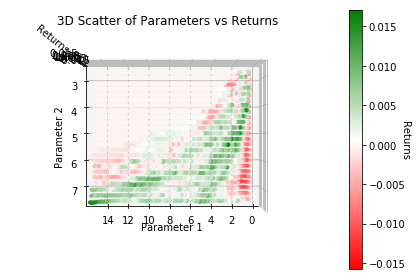

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
cmap = LinearSegmentedColormap.from_list('rg',['r', 'w', 'g'], N=256) 
img = ax.scatter(data[:, 1], data[:, 2], data[:, 0], c=data[:, 0], s=10, cmap=cmap)
cbar = plt.colorbar(img)
cbar.set_label('Returns', rotation=270)
plt.title('3D Scatter of Parameters vs Returns')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
ax.set_zlabel('Returns')
ax.view_init(90, 90)
plt.tight_layout()

### Clustering
SciKit-Learn is a pretty big library and in order to figure out what tool is best to use this [chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) can be quite handy. Using it as I guide I first tried to cluster the data using MeanShift. It took a long time to model only to output few clusters. DBSCAN sounded the most ideal in theory, but ended up making very uneven clusters. Attempting to change the cluster parameters only made it worse.  

In the end K-Means worked well even though it's normally not a suitable model for non flat geometry. On the other hand, of the clustering methods whose usecases aligned with the data set attributes, SpectralClustering was the only one that actually performed as expected.  

### K-Means
There are a little over 3500 data points, so we can begin by using K-Means to cluster them into 100 groups. It's already evident that this is not made to work on multidimensional data and clusting the non trading parameters is a waste of CPU power and time.

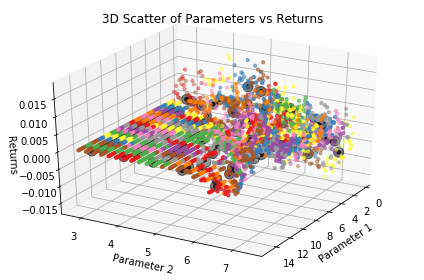

In [5]:
kmeans = KMeans(n_clusters=100, init='k-means++', n_init=15, n_jobs=5)
k_means = kmeans.fit(data)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(data[:, 1], data[:, 2], data[:, 0], c=k_means.labels_, s=10, cmap='Set1')
ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], k_means.cluster_centers_[:, 0], c='k', s=15, alpha=0.75)
ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], k_means.cluster_centers_[:, 0], c='k', s=100, alpha=0.5)
plt.title('3D Scatter of Parameters vs Returns')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
ax.set_zlabel('Returns')
ax.view_init(30, 30)
plt.tight_layout()

This can easily be remedied though. First we multiply all the returns by a constant to scale them to the same order of magnitude as the parameters. Then we can also drop all the data points whose return is 0 because they don't trade and are all in the same area together. K-Means takes the number of clusters as an input, but I prefer to think about it as how many members we want in each cluster. We'll set that we want 50 data points in each cluster and then divide this into the number of data points we have to set as the K-Mean cluster number input.

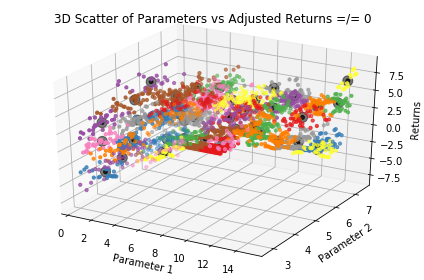

In [6]:
profitable = data[data[:, 0] != 0]
profitable[:, 0] = profitable[:, 0]*500

n_per_group = 50
kmeans = KMeans(n_clusters=int(len(profitable)/n_per_group), init='k-means++', n_init=50, n_jobs=-1)
k_means = kmeans.fit(profitable)
y_kmeans = k_means.predict(profitable)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(profitable[:, 1], profitable[:, 2], profitable[:, 0], c=y_kmeans, s=10, cmap='Set1')
ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], k_means.cluster_centers_[:, 0], c='k', s=15, alpha=0.75)
ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], k_means.cluster_centers_[:, 0], c='k', s=100, alpha=0.5)
plt.title('3D Scatter of Parameters vs Adjusted Returns =/= 0')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
ax.set_zlabel('Returns')
# ax.view_init(30, 30)
plt.tight_layout()

KMlabels = k_means.labels_
KMcenters = k_means.cluster_centers_

So far so good. Now let's organize all the results into an easy to read dataframe showing displaying the total cluster return and cluster center values. We can then sort this dataframe by total cluster return and cluster center return. We see that K-Means delivers somewhat even sized cluster (relative to other methods), so we know that total cluster return will not be heavily skewed by cluster size.

In [7]:
KMclusters = pd.DataFrame(np.zeros((len(set(KMlabels)), 5)), index=np.arange(0, len(set(KMlabels))), columns=['Tot. Cluster Return', 'Center Return', 'Center Pram. 1', 'Center Pram. 2', 'Size'])

for i in range(0, len(KMlabels)):
    KMclusters.loc[KMlabels[i], 'Tot. Cluster Return'] += profitable[i, 0]
    KMclusters.loc[KMlabels[i], 'Size'] += 1

for i in range(0, len(KMcenters)):
    KMclusters.loc[i, 1:4] = [KMcenters[i, 0], KMcenters[i, 1], KMcenters[i, 2]]

KMtotSort = KMclusters.sort_values('Tot. Cluster Return', ascending=False)
print('Sorted by *Total* Cluster Return\n')
print(KMtotSort.head())

KMcenterSort = KMclusters.sort_values('Center Return', ascending=False)
print('\n\n\nSorted by *Center* Cluster Return\n')
print(KMcenterSort.head())

Sorted by *Total* Cluster Return

    Tot. Cluster Return  Center Return  Center Pram. 1  Center Pram. 2  Size
33           232.927763       3.375765        2.888406        5.820290  69.0
34           203.587713       4.626993        4.275000        6.018182  44.0
32           194.340304       4.416825        1.727273        4.622727  44.0
8            191.176097       2.389701        3.608750        4.892500  80.0
15           179.594685       2.993245       10.343333        6.980000  60.0



Sorted by *Center* Cluster Return

    Tot. Cluster Return  Center Return  Center Pram. 1  Center Pram. 2  Size
28            89.026362       6.359026       14.335714        7.400000  14.0
18           145.106412       6.308974        2.169565        5.121739  23.0
42            98.872539       5.203818        9.652632        6.621053  19.0
34           203.587713       4.626993        4.275000        6.018182  44.0
44           115.374214       4.437470       11.188462        6.723077  26.0


It should come as no surprise that the results of sorting by different return metrics give very different results. Clusters with abnormally large returns likely contain a single parameter combination that is overfitted to the dataset and makes a lot of money. It is ideal to find a cluster that gives consistent returns opposed to an anomaly one that sees big gains. While it is not included in this example number of transactions is a very good metric to use here for decision making for two reasons:
* High number of transactions implies a lot of trades consistently make small amounts of money - reliability
* It also implies that positions are held for smaller periods of time - low risk exposure  

Anyway, we don't have those data in this example so we'll have to select data another way. One of the simplest, yet effective ways to select a cluster is to work from top to bottom of both lists simultaneously and find a cluster that is a similarly ranked position in both. We'll stop at the first cluster we find that satisifes this condition. I wrote a simple function to do this and in this case the maximum distance between list positions is set at 5. This will guarantee that overall cluster return and individual data point returns are both high.  

Then the indivudal data points of this cluster are collected and printed. Then we compare the average values of the cluster to the center values.

In [8]:
index1 = KMtotSort.index
index2 = KMcenterSort.index

def KMindexer(index1, index2):
    for i in range(0, 10):
        for j in range(i, i+5):
            if(index1[i] == index2[j]):
                index = index2[j]
                return index

index = KMindexer(index1, index2)
            
KMbestClst = np.zeros((1, 3))
for i in range(0, len(KMlabels)):
    if(KMlabels[i] == index):
        KMbestClst = np.vstack((KMbestClst, [profitable[i, 0], profitable[i, 1], profitable[i, 2]]))

KMbestClst[:, 0] = KMbestClst[:, 0]/500
print('Individual Values of the \"Best\" Cluster\n')
print(KMbestClst[1:, :])

print('\n\nAverage Return, Parameter 1, and Parameter 2 of Best Cluster')
KMbestCenter = [np.mean(KMbestClst[:, 0]), np.mean(KMbestClst[:, 1]), np.mean(KMbestClst[:, 2])]
KMbestCenter[0], KMbestCenter[1], KMbestCenter[2] = round(KMbestCenter[0], 7), round(KMbestCenter[1], 7), round(KMbestCenter[2], 7)
print(KMbestCenter)

print('\ncompared to\n')
# print(SCcenterSort)

print('Center Return, Parameter 1, and Parameter 2 of Best Cluster')
KMbestCenter = np.array(KMcenterSort.loc[index, :])
KMbestCenter = KMbestCenter[1:]
KMbestCenter[0] = KMbestCenter[0]/500
print(KMbestCenter)

Individual Values of the "Best" Cluster

[[9.2719180e-03 3.5000000e+00 4.8000000e+00]
 [7.5215470e-03 4.8000000e+00 5.0000000e+00]
 [7.5485170e-03 4.9000000e+00 5.0000000e+00]
 [7.9638890e-03 3.9000000e+00 5.2000000e+00]
 [8.6804890e-03 4.0000000e+00 5.2000000e+00]
 [8.3115310e-03 4.3000000e+00 5.2000000e+00]
 [8.0586100e-03 4.2000000e+00 5.4000000e+00]
 [8.1756210e-03 4.4000000e+00 5.4000000e+00]
 [9.9400380e-03 4.5000000e+00 5.4000000e+00]
 [8.8071660e-03 4.7000000e+00 5.4000000e+00]
 [9.9464750e-03 4.8000000e+00 5.4000000e+00]
 [7.3921430e-03 4.9000000e+00 5.4000000e+00]
 [9.2228330e-03 3.3000000e+00 5.6000000e+00]
 [8.7835310e-03 3.3000000e+00 5.8000000e+00]
 [1.0731674e-02 3.5000000e+00 5.8000000e+00]
 [9.8293110e-03 3.6000000e+00 5.8000000e+00]
 [9.8861740e-03 3.9000000e+00 5.8000000e+00]
 [8.8407850e-03 4.0000000e+00 5.8000000e+00]
 [9.0473350e-03 4.1000000e+00 5.8000000e+00]
 [8.6456390e-03 3.7000000e+00 6.0000000e+00]
 [9.7985350e-03 3.9000000e+00 6.0000000e+00]
 [9.7303790e-0

Both average cluster values and center values are quite close in terms of location in the cluster. We could further add safety contraints such as ensuring the parameters chosen are not on the outskirts and extremeties of the cluster or that it's not an anomaly point (eg. super high or low return relaitve to the cluster). Here for simplicity we'll take the center cluster values as the optimal parameters for our trading strategy.

### SpectralClustering
Now we can do this all over again with SpectralClustering. This clustering method is well suited to multidimensional data where few clusters are created, but they have a similar number of members. First the entire data set is clustered.

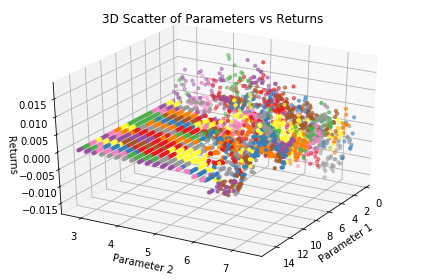

In [9]:
spclst = SpectralClustering(n_clusters=100, n_init=15, n_jobs=-1)
sp_clst = spclst.fit(data)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(data[:, 1], data[:, 2], data[:, 0], c=sp_clst.labels_, s=10, cmap='Set1')
plt.title('3D Scatter of Parameters vs Returns')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
ax.set_zlabel('Returns')
ax.view_init(30, 30)
plt.tight_layout()

It's hard to make any definitive comment about the above plot, but I would argue that it's an improvement. Next we'll cluster only the data points associated to non 0 returns (aka non trading parameters) and then we see that the clusters are more clearly defined.

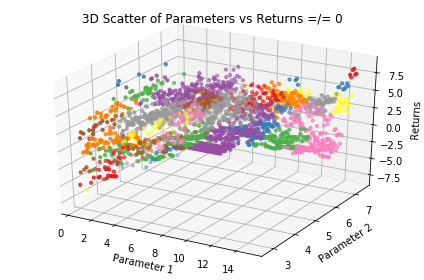

In [10]:
spclst = SpectralClustering(n_clusters=int(len(profitable)/n_per_group), n_init=15, n_jobs=-1)
sp_clst = spclst.fit(profitable)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(profitable[:, 1], profitable[:, 2], profitable[:, 0], c=sp_clst.labels_, s=10, cmap='Set1')
plt.title('3D Scatter of Parameters vs Returns =/= 0')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
ax.set_zlabel('Returns')
# ax.view_init(30, 30)
plt.tight_layout()

SClabels = sp_clst.labels_

Once again we'll collect the total cluster return, total cluster size, and use these two attributes to calculate the average cluster return. The dataframe is plotted twice sorted by the two return metrics. For those who thought K-Means delivering even sized clusters was a bold claim before, please see the variation in cluster members below from SpectralClustering.

In [11]:
SCclusters = pd.DataFrame(np.zeros((len(set(SClabels)), 3)), index=np.arange(0, len(set(SClabels))), columns=['Tot. Cluster Return', 'Average Return', 'Cluster Members'])

for i in range(0, len(SClabels)):
    SCclusters.loc[SClabels[i], 'Tot. Cluster Return'] += profitable[i, 0]
    SCclusters.loc[SClabels[i], 'Cluster Members'] += 1

SCclusters.loc[:, 'Average Return'] = SCclusters.loc[:, 'Tot. Cluster Return']/SCclusters.loc[:, 'Cluster Members']

SCtotSort = SCclusters.sort_values('Tot. Cluster Return', ascending=False)
print('Sorted by Total Cluster Return\n')
print(SCtotSort.head())

SCaverageSort = SCclusters.sort_values('Average Return', ascending=False)
print('\n\n\nSorted by Average Return\n')
print(SCaverageSort.head())

Sorted by Total Cluster Return

    Tot. Cluster Return  Average Return  Cluster Members
17           592.446596        3.202414            185.0
45           370.621757        2.003361            185.0
1            255.025043        2.684474             95.0
43           221.857436        2.073434            107.0
41           198.119571        3.095618             64.0



Sorted by Average Return

    Tot. Cluster Return  Average Return  Cluster Members
6             38.191163        7.638233              5.0
4             45.424773        7.570796              6.0
19            39.790541        6.631757              6.0
5             25.450897        6.362724              4.0
7             43.601589        5.450199              8.0


It's a remarkably different result from K-Means. We can use the same indexing method to pick a cluster but since these two dataframes are unlikely to have rank overlap we will extend that max rank range to 7 (eg. find the highest ranked cluster in one list that appears within 7 places on the other). Then the average values of the cluster are calculated and we arbitrarily pick the data point in the center of the list.

In [12]:
index1 = SCtotSort.index
index2 = SCaverageSort.index

def SCindexer(index1, index2):
    for i in range(0, len(index1)):
        for j in range(i, i+7):
            if(index1[i] == index2[i]):
               return index2[i]
           
index = SCindexer(index1, index2)
            
SCbestClst = np.zeros((1, 3))
for i in range(0, len(SClabels)):
    if(SClabels[i] == index):
        SCbestClst = np.vstack((SCbestClst, [profitable[i, 0], profitable[i, 1], profitable[i, 2]]))

SCbestClst[:, 0] = SCbestClst[:, 0]/500
print('Individual Values of the \"Best\" Cluster\n')
print(SCbestClst[1:, :])

print('\n\nAverage Return, Parameter 1, and Parameter 2 of Best Cluster')
SCbestCenter = [np.mean(SCbestClst[:, 0]), np.mean(SCbestClst[:, 1]), np.mean(SCbestClst[:, 2])]
SCbestCenter[0], SCbestCenter[1], SCbestCenter[2] = round(SCbestCenter[0], 7), round(SCbestCenter[1], 7), round(SCbestCenter[2], 7)
print(SCbestCenter)

print('\n\nMiddle of List Return, Parameter 1, and Parameter 2 of Best Cluster')
SCbestClst = SCbestClst[1:, :]
middle = int(len(SCbestClst)/2)
SCbest = SCbestClst[middle, :]
print(SCbest)

Individual Values of the "Best" Cluster

[[0.01091977 1.2        4.        ]
 [0.00994376 1.5        4.        ]
 [0.00896627 2.4        4.        ]
 [0.01010732 1.4        4.4       ]
 [0.01089946 1.4        4.6       ]
 [0.0090885  1.5        4.6       ]
 [0.01142971 1.6        4.6       ]
 [0.00965296 1.7        4.6       ]
 [0.0100518  1.8        4.6       ]
 [0.00919897 1.9        4.6       ]
 [0.00918889 1.6        4.8       ]
 [0.00958896 1.7        4.8       ]
 [0.00841404 2.1        4.8       ]
 [0.01121273 2.3        4.8       ]
 [0.00866047 2.4        4.8       ]
 [0.00924138 1.6        5.        ]
 [0.00933617 1.7        5.        ]
 [0.01107607 1.9        5.        ]
 [0.01130721 2.         5.        ]
 [0.00961988 2.1        5.        ]
 [0.00970761 2.2        5.        ]
 [0.00996943 2.3        5.        ]
 [0.01126642 2.4        5.        ]
 [0.00899615 2.5        5.        ]
 [0.01022433 1.7        5.2       ]
 [0.00964857 1.8        5.2       ]
 [0.00991516 1.9       

We find that they're similar in values, but not as close as those found by K-Means. The average values are then chosen.
### Machine Learning
Another way to go about this is to train a model to recognize the hypothetical returns of certain parameter combinations. Imagine a very complex strategy is taking forever to backtest. We can take an incomplete set of results and use them to train a basic machine learning algorithm. Then we can use it to predict which parameters will give positive return. If there's an immense push to get a new strategy live this can be a short cut if brute force backtesting is taking too long.

### Train and Test Data
The first thing to do is split our data set into training data to train the model and testing data for validation. Here  80% of the data is taken for training and 20% for testing. The 20% are chosen at evenly spaces intervals opposed to the top or bottom of the whole data set or at random.

In [13]:
parameters = np.vstack((data[:, 1], data[:, 2])).T
returns = np.array(data[:, 0])

testers = np.linspace(0, len(data)-1, int((len(data)-1)*.2))
for i in range(0, len(testers)):
    testers[i] = int(testers[i])

testParameters, testReturns = [], []
for i in testers:
    testParameters.append([data[int(i), 1], data[int(i), 2]])
    testReturns.append(data[int(i), 0])
    parameters[int(i), :] = [np.nan, np.nan]
    returns[int(i)] = np.nan

parameters = pd.DataFrame(parameters)
parameters = np.array(parameters.dropna())

returns = returns[np.isfinite(returns)]

### Model Selection
SciKit-Learn offers a plethera of machine learning classification and regression models. We can use the [chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) again if necessary, but we know that we need a regression model as the verification values are continuous numbers opposed to fixed categories. Stochastic Gradient Descent is a great machine learning model as are DecisionTrees. We can also try a SupportVectorMachine, which have been largely replaced by neural networks, and a Ridge. The models are then trained on the test data.  

Tuning each one of these models warrants an even more in depth post than what is shown here to tune an algorithm trading strategy, but that's an adventure for another time.

In [14]:
rgr_SGD = linear_model.SGDRegressor(loss='squared_loss', alpha=0.0005, learning_rate='invscaling', max_iter=1000, shuffle=True)
rgr_SVR = SVR(kernel='linear', gamma='auto')
rgr_ridge = linear_model.Ridge(solver='auto', max_iter=1000)
rgr_tree = tree.DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, presort=False)

rgr_SGD.fit(parameters, returns)
rgr_SVR.fit(parameters, returns)
rgr_ridge.fit(parameters, returns)
rgr_tree.fit(parameters, returns)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Next the models are each tested on the validation data and different scoring metrics for their erros are printed in a dataframe.

In [15]:
scores = pd.DataFrame(np.zeros((3, 4)), index=['Absolute Error', 'Variance Score', 'Mean Sq. Error'], columns=['SGD', 'SVR', 'Ridge', 'Tree'])

pred_SGD = rgr_SGD.predict(testParameters)
scores.loc['Absolute Error', 'SGD'] = mean_absolute_error(testReturns, pred_SGD)
scores.loc['Variance Score', 'SGD'] = explained_variance_score(testReturns, pred_SGD)
scores.loc['Mean Sq. Error', 'SGD'] = mean_squared_error(testReturns, pred_SGD)

pred_SVR = rgr_SVR.predict(testParameters)
scores.loc['Absolute Error', 'SVR'] = mean_absolute_error(testReturns, pred_SVR)
scores.loc['Variance Score', 'SVR'] = explained_variance_score(testReturns, pred_SVR)
scores.loc['Mean Sq. Error', 'SVR'] = mean_squared_error(testReturns, pred_SVR)

pred_ridge = rgr_ridge.predict(testParameters)
scores.loc['Absolute Error', 'Ridge'] = mean_absolute_error(testReturns, pred_ridge)
scores.loc['Variance Score', 'Ridge'] = explained_variance_score(testReturns, pred_ridge)
scores.loc['Mean Sq. Error', 'Ridge'] = mean_squared_error(testReturns, pred_ridge)

pred_tree = rgr_tree.predict(testParameters)
scores.loc['Absolute Error', 'Tree'] = mean_absolute_error(testReturns, pred_tree)
scores.loc['Variance Score', 'Tree'] = explained_variance_score(testReturns, pred_tree)
scores.loc['Mean Sq. Error', 'Tree'] = mean_squared_error(testReturns, pred_tree)

print(scores)

                     SGD       SVR     Ridge      Tree
Absolute Error  0.002497  0.002726  0.002475  0.001075
Variance Score  0.064384  0.000000  0.064939  0.769022
Mean Sq. Error  0.000014  0.000015  0.000014  0.000004


The DecisionTree outperforms the others on all metrics so we'll only use this model to finally predict returns based on parameters. Below the DecisionTree is used to predict the return of the parameters chosen by both clustering methods. Additionally I picked 2 parameter combinations just by inuition and looking at the exploratory plots and the returns based on these hand selected inputs are shown as well.

In [16]:
print('Return / Parameter 1 / Parameter 2 as Chosen by K-Means')
print(KMbestCenter[:3])
hypReturn = rgr_tree.predict([KMbestCenter[1:3]])
print('Return Predicted')
print(hypReturn)

print('\nReturn / Parameter 1 / Parameter 2 as Chosen by SpectralClustering')
print(SCbestCenter[:3])
hypReturn = rgr_tree.predict([SCbestCenter[1:3]])
print('Return Predicted')
print(hypReturn)

print('\nReturn Predicted from User Selected Parameters [12, 7]')
hypReturn = rgr_tree.predict([[12, 7]])
print(hypReturn)

print('\nReturn Predicted from User Selected Parameters [2, 5.5]')
hypReturn = rgr_tree.predict([[2, 5.5]])
print(hypReturn)

Return / Parameter 1 / Parameter 2 as Chosen by K-Means
[0.00925399 4.275      6.01818182]
Return Predicted
[0.01001262]

Return / Parameter 1 / Parameter 2 as Chosen by SpectralClustering
[0.0098538, 1.9459459, 4.8162162]
Return Predicted
[0.00749208]

Return Predicted from User Selected Parameters [12, 7]
[0.00629725]

Return Predicted from User Selected Parameters [2, 5.5]
[0.00944994]


In the end the parameters picked by the different clustering methods aren't as close as I would've thought, but they both have empiracally high returns (note that the returns have been scaled back down to their orignal values after being manipulated for clustering). The predictions made by the DecisionTree also indicate that these are positive returning strategy inputs. My own selections weren't too bad either, but the models definitely did better and there's a chance that since I picked round numbers the DecisionTree has already been trained on these inputs. Regardless with more data (not just quantity, but also information like number of trades, % of winning trades, etc.) the models will slowly improve and be able to regularly decide what the optimal parameters are for a live code. I can attest that if done well this will make money.  

Lastly it's important to note that these results are most likely unique to the coin pair the backtesting was conducted on. There is a possibility parameters found for this trading strategy can be used with other coin pairs, but that is a high risk gamble.